# 요약

* 이전에는 단순 FCL 구조로 하여 실패
* 이번에는 2차원 컨볼루션 층을 추가해봄
* 2차원 컨볼루션이므로 데이터 구조도 일시적으로 2차원으로 reshape하여 처리함
* 그러나 실패.
* 억지로 2차원 이미지 처리 과정으로 해서 그런듯하다.
* 1차원 컨볼루션을 고려해야 할듯..

In [0]:
# Library import

import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
N = 5  # Maximum number of possible peak
Data_number = 300000

Parameters = np.zeros((Data_number, N, 2))  # Set of Parameters ready
print(Parameters.shape[1])

5


In [0]:
# Lorentzian function that returns sum of multi-Lorentzian function with two arguments

def Lorentzian(x, *args):
    ''' returns sum of Multi-Lorentzian function 
    corresponding to each two arguments (a, b)'''
    a = args[::2]
    b = args[1::2]

    result = 0
    for i in range(len(a)):
        if a[i] > 0 and b[i] > 0:
            if len(a) == len(b):
                result += b[i] ** 2 / ((x - a[i])**2 + b[i]**2)
    return result

In [4]:
# X-domain fixed
x = np.arange(-2, 2, 0.01)
len(x)

400

In [5]:
for i in range(len(Parameters)): # For each matrix in Parameter set...

    for j in range(Parameters.shape[1]): # For each raw in each matrix...
        
        # append two argument that will be used in Lorentzian function
        # Second parameter is constrained in range (0.1 ~ 0.2)
        Parameters[i][j] = np.array([[np.random.rand(), 0.1*np.random.rand() + 0.1]])
    
# Check out
print(Parameters)

[[[0.25523385 0.13902095]
  [0.23780278 0.1634695 ]
  [0.3329558  0.15204116]
  [0.85989757 0.16465124]
  [0.02435366 0.16699067]]

 [[0.5576175  0.13348041]
  [0.12497738 0.13660627]
  [0.13821914 0.11648377]
  [0.87576562 0.19284364]
  [0.74189779 0.11921753]]

 [[0.74725947 0.13346998]
  [0.26555564 0.17619098]
  [0.17728703 0.19364803]
  [0.85080308 0.17728319]
  [0.03334006 0.11937545]]

 ...

 [[0.95723365 0.16012168]
  [0.57458654 0.14653316]
  [0.86519581 0.16500682]
  [0.20305967 0.16159804]
  [0.59173391 0.19262835]]

 [[0.73443098 0.12735088]
  [0.06930689 0.12279381]
  [0.44294225 0.12845552]
  [0.04166965 0.14196853]
  [0.18983027 0.12173373]]

 [[0.42062921 0.10652403]
  [0.91854189 0.18971335]
  [0.73243815 0.14193842]
  [0.15772082 0.11896621]
  [0.07163414 0.19021054]]]


In [0]:
# ================== Data Generating ================
train_x = []
train_y = []

for j in Parameters:  # For each parameter matrix...

    peak = random.randint(2, N) # Random selection of Possible peak number
    j = list(j.reshape((2*N, ))) # reshape processing to put it as *args in function, Since j is matrix
    
    # 무의미한 파라미터는 0 라벨로 처리
    if peak == 1:
        train_x.append(Lorentzian(x, *j[0:2]))
        train_y.append(np.array([j[0], j[1] , 0, 0, 0, 0, 0, 0, 0, 0]))

    elif peak == 2:
        train_x.append(Lorentzian(x, *j[0:4]))
        train_y.append(np.array([j[0], j[1], j[2], j[3], 0, 0, 0, 0, 0, 0]))

    elif peak == 3:
        train_x.append(Lorentzian(x, *j[0:6]))
        train_y.append(np.array([j[0], j[1], j[2], j[3], j[4], j[5], 0, 0, 0, 0]))

    elif peak == 4:
        train_x.append(Lorentzian(x, *j[0:8]))
        train_y.append(np.array([j[0], j[1], j[2], j[3], j[4], j[5], j[6], j[7], 0, 0]))

    elif peak == 5:
        train_x.append(Lorentzian(x, *j[0:]))
        train_y.append(np.array([j[0], j[1], j[2], j[3], j[4], j[5], j[6], j[7], j[8], j[9]]))




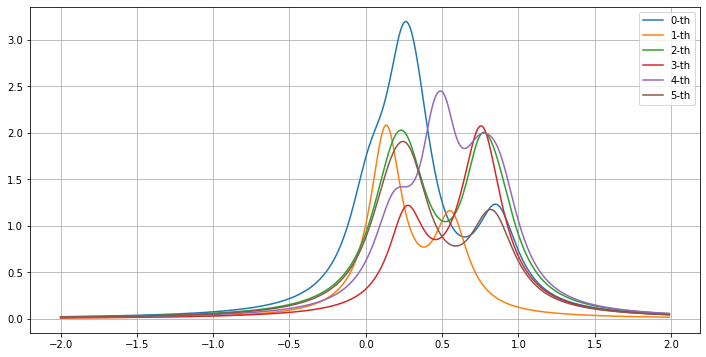

In [9]:
# Generated Data sample check!
plt.figure(figsize=(12, 6))

for i in range(6):
    plt.plot(x, train_x[i], label = str(i) + '-th')
    plt.legend()
    plt.grid('on')

In [0]:
# Data spliting up into three group : training/validation/test

train_data = np.array(train_x[:150000])
val_data = np.array(train_x[150000:250000])
test_data = np.array(train_x[250000:])

train_labels = np.array(train_y[:150000])
val_labels = np.array(train_y[150000:250000])
test_labels = np.array(train_y[250000:])

In [11]:
# size test

print(train_data.shape, train_labels.shape)
print(val_data.shape, val_labels.shape)
print(test_data.shape, test_labels.shape)

(150000, 400) (150000, 10)
(100000, 400) (100000, 10)
(50000, 400) (50000, 10)


In [0]:
# reshape for Image-form setting
train_data = train_data.reshape(150000, 20, 20, 1)
val_data = val_data.reshape(100000, 20, 20, 1)
test_data = test_data.reshape(50000, 20, 20, 1)


In [14]:
# From Here on, let`s start to make Convolution Neural Network!

# Library import
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Modeling
model2 = Sequential()

model2.add(Conv2D(32, (8, 8), activation='relu', input_shape=(20, 20, 1), 
                  kernel_initializer="glorot_uniform"))
model2.add(MaxPooling2D())

model2.add(Conv2D(16, (4, 4), activation='relu',
                  kernel_initializer="glorot_uniform"))
model2.add(MaxPooling2D())

# Fully-Connected Layers
model2.add(Flatten())
model2.add(Dense(200, activation = 'relu'))
model2.add(Dense(10, activation = 'linear'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 13, 13, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 16)          8208      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               3400      
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

In [0]:
# Training Method setting for Regression
model2.compile(loss='mse', metrics=['mae'], optimizer=Adam())


In [16]:
# Training Start!
%%time
hist2 = model2.fit(train_data, train_labels, 
                   epochs=30, 
                   batch_size=2000,
                   validation_data=(val_data, val_labels), verbose=2)

Epoch 1/30
75/75 - 1s - loss: 0.0422 - mae: 0.1389 - val_loss: 0.0292 - val_mae: 0.1115
Epoch 2/30
75/75 - 1s - loss: 0.0274 - mae: 0.1054 - val_loss: 0.0257 - val_mae: 0.0991
Epoch 3/30
75/75 - 1s - loss: 0.0246 - mae: 0.0958 - val_loss: 0.0239 - val_mae: 0.0934
Epoch 4/30
75/75 - 1s - loss: 0.0232 - mae: 0.0902 - val_loss: 0.0229 - val_mae: 0.0894
Epoch 5/30
75/75 - 1s - loss: 0.0226 - mae: 0.0872 - val_loss: 0.0224 - val_mae: 0.0856
Epoch 6/30
75/75 - 1s - loss: 0.0222 - mae: 0.0855 - val_loss: 0.0224 - val_mae: 0.0873
Epoch 7/30
75/75 - 1s - loss: 0.0221 - mae: 0.0850 - val_loss: 0.0221 - val_mae: 0.0861
Epoch 8/30
75/75 - 1s - loss: 0.0219 - mae: 0.0839 - val_loss: 0.0218 - val_mae: 0.0830
Epoch 9/30
75/75 - 1s - loss: 0.0218 - mae: 0.0833 - val_loss: 0.0217 - val_mae: 0.0826
Epoch 10/30
75/75 - 1s - loss: 0.0218 - mae: 0.0830 - val_loss: 0.0219 - val_mae: 0.0853
Epoch 11/30
75/75 - 1s - loss: 0.0217 - mae: 0.0829 - val_loss: 0.0216 - val_mae: 0.0826
Epoch 12/30
75/75 - 1s - loss:

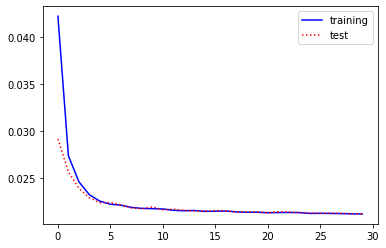

In [17]:
# Plotting loss graph
plt.plot(hist2.history['loss'], 'b-', label="training")
plt.plot(hist2.history['val_loss'], 'r:', label="test")
plt.legend()
plt.show()

In [18]:
# Prediction

predict = model2.predict(test_data)
print(predict)

[[ 2.9651767e-01  1.5609272e-01  3.0595139e-01 ...  9.2717018e-03
  -6.4299069e-04  7.6986663e-03]
 [ 7.1215934e-01  1.2112724e-01  7.1339279e-01 ... -4.7874018e-03
  -2.1787751e-03  1.9575953e-03]
 [ 7.0129591e-01  1.2377170e-01  7.0394009e-01 ... -2.7281209e-03
   6.0869567e-04  5.6293420e-04]
 ...
 [ 8.0383867e-01  1.5768920e-01  8.2503372e-01 ...  4.4813612e-04
  -3.2544676e-03  1.6600974e-03]
 [ 3.1136596e-01  1.3181216e-01  3.1490511e-01 ...  1.3411549e-01
   3.7030783e-03  4.1317940e-04]
 [ 7.0970231e-01  1.4864503e-01  7.1676701e-01 ...  1.8082098e-03
  -1.9359346e-03  4.3829922e-03]]


In [19]:
predict[2].shape

(10,)

In [0]:
test_data = test_data.reshape((50000, 400))

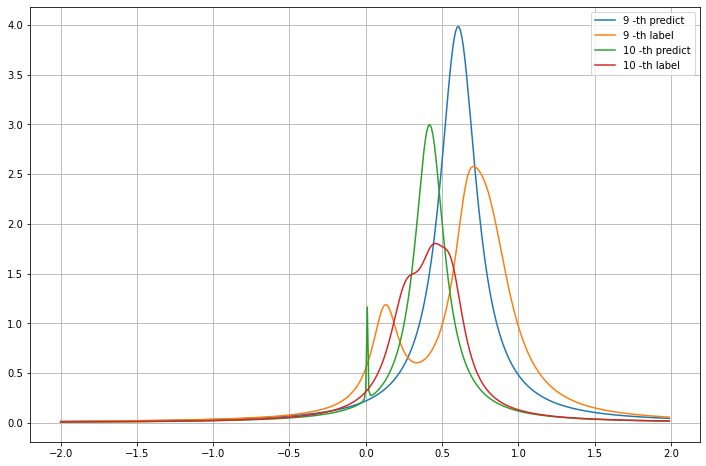

In [21]:
plt.figure(figsize=(12, 8))

for i in range(9, 11):
    plt.plot(x, Lorentzian(x, *list(predict[i])), label = str(i) + ' -th predict')
    plt.plot(x, test_data[i], label = str(i) + ' -th label')
    plt.legend()
    plt.grid('on')

# 실패..